In [103]:
import requests
import json
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

# Liquidity on Simplified AMM 

We study Paradigm's derivation of liquidity as market depth for constant product AMMs by applying it to Uniswap V2 ETH/SAI. 

## Background
Spot price of an asset on an exchange is governed by supply and demand, therefore a large buy or sell order will impact the price. Liquidity measures the ability of buying or selling a particular quantity of assets within a price impact range, or equivalently, the price impact of buying or selling a particular order size. In this definition, liquidity is equivalent to market depth.

Liquidity answers the following:
- What is the price impact for buying or selling a given quantity of assets?
- How much assets can be sold or bought for a given price impact?

Measuring liquidity is necessary for trading:
- Avoid large positions in illiquid assets
- Factor price impact for realistic performance
- (Adversarial) Target illiquid assets for price impact advantages

## Formula

### Centralized Exchanges

The price of an asset on a centralized exchange (CEX) is the equilibrium or mid price of the highest bid and the lowest ask. 

Liquidity in CEX is calculated by aggregating the limit orders at each price level in a central limit order book (CLOB).

For a given % price range $d$ from price level $l$:

$$m(d)_{bid, range} = \sum_{l}^{(1+d)l} ({bids_l * price_l})$$

$$m(d)_{ask, range} = \sum_{l}^{(1+d)l} ({asks_l * price_l})$$

For example, at 2% price range (or 2% market depth) for an asset, a trader can sell a quantity less than or equal to $m(d)_{ask, 2\%}$

### Decentralized Exchanges

The CEX liquidity formula is not available for decentralized exchanges (DEX) because DEXs do not operate on CLOBs. The most popular ones such as Uniswap and Curve operate on constant product AMMs (automated market makers). 

An AMM is a pool that consists of at least 2 assets that are bonded by a constant product. For an AMM that consists of asset $x$ and asset $y$, its constant product $k$ and equilibrium price $p$ of asset $x$ is given by 

$$x * y = k$$

$$P = \frac{y}{x}$$

There are two types of interactions available with AMMs for normal users:
1. Swaps: X -> Y or Y -> X
2. Add liquidity to both X and Y in the ratio dictated by the constant product k

In a swap, $\triangle x$ units of asset $x$ is exchanged for $\triangle y$ units of asset $y$:

$$(x + \triangle x)(y + \triangle y) = k$$

We present price as:
$$p = \frac{k}{x^2}$$

In [5]:
uniswap_events = pd.read_pickle('data/kaggle/uniswap_events.pickle')

In [7]:
uniswap_events.dtypes

transactionHash                    object
transaction_index                   int64
transaction_sender                 object
address                            object
data                               object
topics                             object
block_timestamp       datetime64[ns, UTC]
blockNumber_dec                     int64
contract                           object
event                              object
contract_event                     object
block_group                         int64
agent                              object
eth_delta                          object
token_delta                        object
uni_delta                          object
eth_balance                        object
token_balance                      object
UNI_supply                         object
invariant                          object
dtype: object

In [ ]:
uniswap_events.describe()

,transaction_index,blockNumber_dec,block_group
count,177201.000000,1.772010e+05,177201.000000
mean,73.605256,8.407613e+06,840.262453
std,51.033516,7.258453e+05,72.584914
min,0.000000,6.629139e+06,662.000000
25%,32.000000,7.832453e+06,783.000000
50%,65.000000,8.366990e+06,836.000000
75%,107.000000,8.998585e+06,899.000000
max,418.000000,9.711652e+06,971.000000


In [29]:
uniswap_events.head(5)

,transactionHash,transaction_index,transaction_sender,address,data,topics,block_timestamp,blockNumber_dec,contract,event,contract_event,block_group,agent,eth_delta,token_delta,uni_delta,eth_balance,token_balance,UNI_supply,invariant
0,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9a...,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x06239653922ac7bea6aa2b19dc486b9361821d37712...,2018-11-02 10:27:36+00:00,6629139,SAI,AddLiquidity,SAIAddLiquidity,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,30000000000000000000,5900000000000000000000,0,30000000000000000000,5900000000000000000000,0,177000000000000000000000000000000000000000
1,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9a...,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,2018-11-02 10:27:36+00:00,6629139,SAI,Transfer,SAITransfer,662,0x0000000000000000000000000000000000000000,0,0,30000000000000000000,30000000000000000000,5900000000000000000000,30000000000000000000,177000000000000000000000000000000000000000
2,0xd53f01fc0cabbf4083da93a023ddb81de91320027077...,97,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427...,2018-11-02 10:33:56+00:00,6629171,SAI,EthPurchase,SAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-25326059253325791,5000000000000000000,0,29974673940746674209,5905000000000000000000,30000000000000000000,177000449620109111204145000000000000000000
3,0x53172898dbe437c784f7e4ac757087b28d1b06aa6b72...,53,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427...,2018-11-02 10:35:47+00:00,6629177,SAI,EthPurchase,SAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-10118429075406013,2000000000000000000,0,29964555511671268196,5907000000000000000000,30000000000000000000,177000629407442181233772000000000000000000
4,0x6cef57fd37d7a2602c1236ff080c61c37e10980c7e3b...,24,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,2018-11-02 10:38:18+00:00,6629190,SAI,TokenPurchase,SAITokenPurchase,662,0x11e4857bb9993a50c685a79afad4e6f65d518dda,10000000000000000,-1964761376358359468,0,29974555511671268196,5905035238623641640532,30000000000000000000,177000806558499339943044863018842396120272


In [47]:
display(uniswap_events.loc[0])

transactionHash       0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9a...
transaction_index                                                   150
transaction_sender           0xf369af914dbed0ad7afdddebc631ee0fda1b4891
address                      0x09cabec1ead1c0ba254b09efb3ee13841712be14
data                                                                 0x
topics                [0x06239653922ac7bea6aa2b19dc486b9361821d37712...
block_timestamp                               2018-11-02 10:27:36+00:00
blockNumber_dec                                                 6629139
contract                                                            SAI
event                                                      AddLiquidity
contract_event                                          SAIAddLiquidity
block_group                                                         662
agent                        0xf369af914dbed0ad7afdddebc631ee0fda1b4891
eth_delta                                          3000000000000

In [90]:
uniswap_daily = uniswap_events.resample('1d', on='block_timestamp').last()

In [91]:
uniswap_daily

,transactionHash,transaction_index,transaction_sender,address,data,topics,blockNumber_dec,contract,event,contract_event,block_group,agent,eth_delta,token_delta,uni_delta,eth_balance,token_balance,UNI_supply,invariant
block_timestamp,,,,,,,,,,,,,,,,,,,
2018-11-02 00:00:00+00:00,0xaab9469f40763753542926359512c808256d13097ebe...,60,0xad850d65eb5202f828f5f7883bc0b46ac87e64d4,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427...,6632336,SAI,EthPurchase,SAIEthPurchase,663,0xad850d65eb5202f828f5f7883bc0b46ac87e64d4,-158767522629291283,30181200000000000000,0,30496905721695922725,5810153678864157969227,30009659152971520629,177191708972884953934430557966441919983575
2018-11-03 00:00:00+00:00,0x5baa7fe981b5e13e149d945ebe6932a501991fc4ea6c...,196,0x5e72cda034c8dccf53b9eaf8f1716747828b3e88,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,6637885,SAI,TokenPurchase,SAITokenPurchase,663,0x5e72cda034c8dccf53b9eaf8f1716747828b3e88,24782272273264484,-5000000000000000000,0,29619251348900428177,5988861575771812167475,30009659152971520629,177385596306557191392864255704245932943075
2018-11-04 00:00:00+00:00,0xa27719389d05ce82085307ef3fbce2fccbc086ae097f...,144,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,6642910,SAI,TokenPurchase,SAITokenPurchase,664,0x2c4bd064b998838076fa341a83d007fc2fa50957,29520850047131283,-6000000000000000000,0,29513543134818308275,6010546537598189516069,30009659152971520629,177392524501236999011798214726263508170975
2018-11-05 00:00:00+00:00,0x850c3a807bf8ffeb27be75fd9fd360553efbeeea4f20...,57,0x40f09c2272e7e1928874f0463bedcecde8bc0cb2,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,6650723,SAI,TokenPurchase,SAITokenPurchase,665,0x40f09c2272e7e1928874f0463bedcecde8bc0cb2,10000000000000000,-2119567892433935307,0,28911749296991105239,6144355049656710965879,30029824325572591682,177644052787376160789418529660975427140081
2018-11-06 00:00:00+00:00,0xc29804dbff7d8740189f1e25dc67c09556ae2f7a8710...,81,0x212bc2ed72cbc59e9856e8008fd52caff627acb4,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,6656819,SAI,TokenPurchase,SAITokenPurchase,665,0x212bc2ed72cbc59e9856e8008fd52caff627acb4,5000000000000000,-1049198171908205333,0,53801755781103148984,11322659542653079396839,55606076764719036163,609178963506398051344337231180514275661576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-16 00:00:00+00:00,0x7305e6a448b9f3579634b0403c41dcba3da668bdb14f...,11,0xffa5bfe92b6791dad23c7837abb790b48c2f8995,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,9685684,SAI,TokenPurchase,SAITokenPurchase,968,0x8018280076d7fa2caa1147e441352e8a89e1ddbe,880121198700000000,-93251474769057449353,0,1041860092128288063145,110617726545163838949702,569386356200760082819,115248194769366173291192030358133980654932790
2020-03-17 00:00:00+00:00,0x8ec993495f51e27a8976392e59e58335e9a36885acc9...,98,0x55ae3f67039c332f55be00c1d33d989d2da108c5,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427...,9692213,SAI,EthPurchase,SAIEthPurchase,969,0x85c5c26dc2af5546341fc1988b9d178148b4838b,-649956864100505361,73680434573327164143,0,1011801931065481518584,114420412385022621042781,569446614898580050350,115770794204474625809745851933184253510542104
2020-03-18 00:00:00+00:00,0x7a40ea858dca28124b84186cc8306c50bbb87fc0f0cb...,44,0x3eab4037a2e7f4d4d0946c091fe135838221f2b6,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,9698735,SAI,TokenPurchase,SAITokenPurchase,969,0x45a2fdfed7f7a2c791fb1bdf6075b83fad821dde,102417096272686027,-11789817894951317724,0,994060801100304895520,114755432768626908472308,564665225116494661565,114073877428593444000345683186883

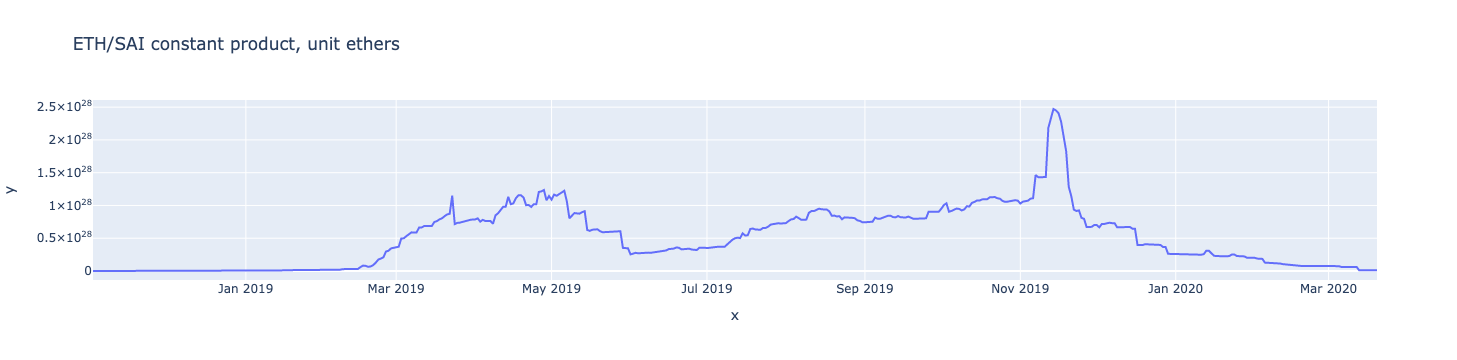

In [140]:
fig = px.line(
    x=uniswap_daily.index,
    y=uniswap_daily.invariant/1e18,
    title='ETH/SAI constant product, unit ethers'
)
fig.show()

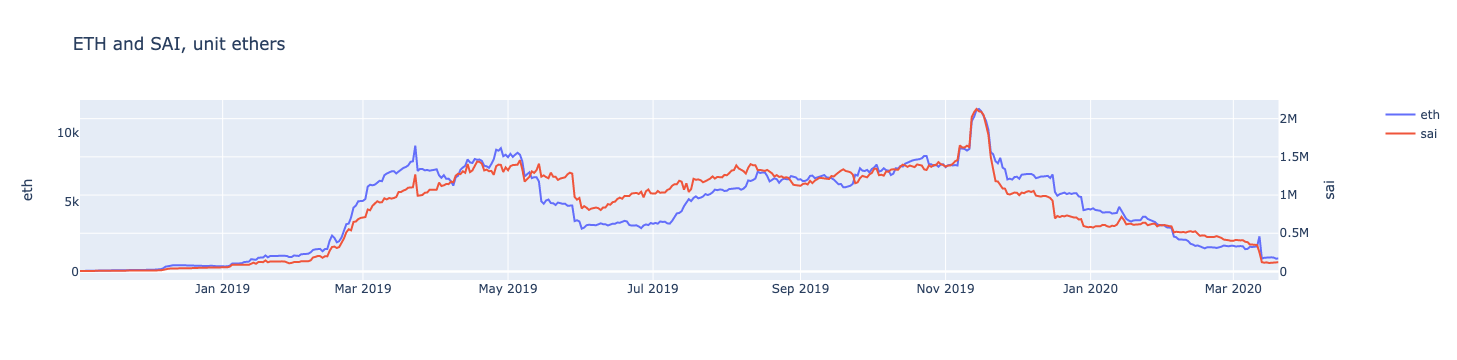

In [139]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(
        x=uniswap_daily.index,
        y=uniswap_daily.eth_balance/1e18,
        name='eth'
    ),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=uniswap_daily.index,
        y=uniswap_daily.token_balance/1e18,
        name='sai'
    ),
    secondary_y=True,
)
fig.update_layout(
    title={
        'text': 'ETH and SAI, unit ethers',
    },
)
fig.update_yaxes(title_text="eth", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="sai", secondary_y=True)
fig.show()

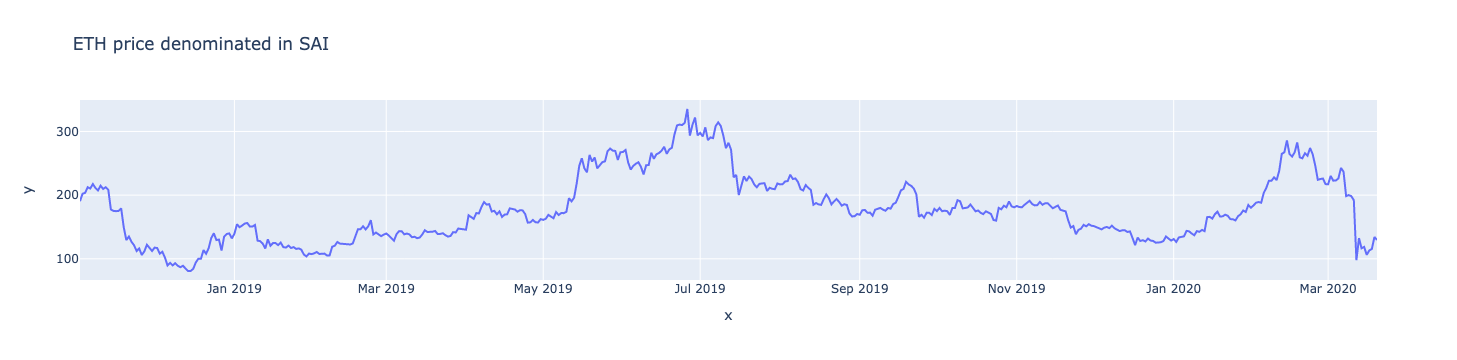

In [138]:
fig = px.line(
    x=uniswap_daily.index,
    y=uniswap_daily.token_balance/uniswap_daily.eth_balance,
    title='ETH price denominated in SAI'
)
fig.show()

In [106]:
eth_response = requests.get(f'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=max&interval=daily').json()

In [111]:
sai_response = requests.get(f'https://api.coingecko.com/api/v3/coins/sai/market_chart?vs_currency=usd&days=max&interval=daily').json()

In [132]:
eth_response.keys()

dict_keys(['prices', 'market_caps', 'total_volumes'])

In [192]:
def constructDF(response, metric, name: str):
    df = pd.DataFrame(response[metric], columns = ['date', name])
    # df['date'] = pd.to_datetime(df['date'],unit='ms').dt.floor('d').astype(str)
    df['date'] = pd.to_datetime(df['date'],unit='ms').dt.floor('d')
    df = df.set_index('date')
    df = df[:-1] #this is to avoid last date dup
    return df

In [206]:
eth_price = pd.concat(
    [
        constructDF(eth_response, 'prices', 'ETH_CEX'),
        pd.DataFrame({'ETH_DEX':uniswap_daily.token_balance/uniswap_daily.eth_balance}).tz_localize(None)
    ],
    axis=1,
    join='inner'
)


In [214]:
eth_price['ETH_DEX'] = pd.to_numeric(eth_price['ETH_DEX'])

In [219]:
eth_price['spread'] = eth_price['ETH_CEX'] - eth_price['ETH_DEX']

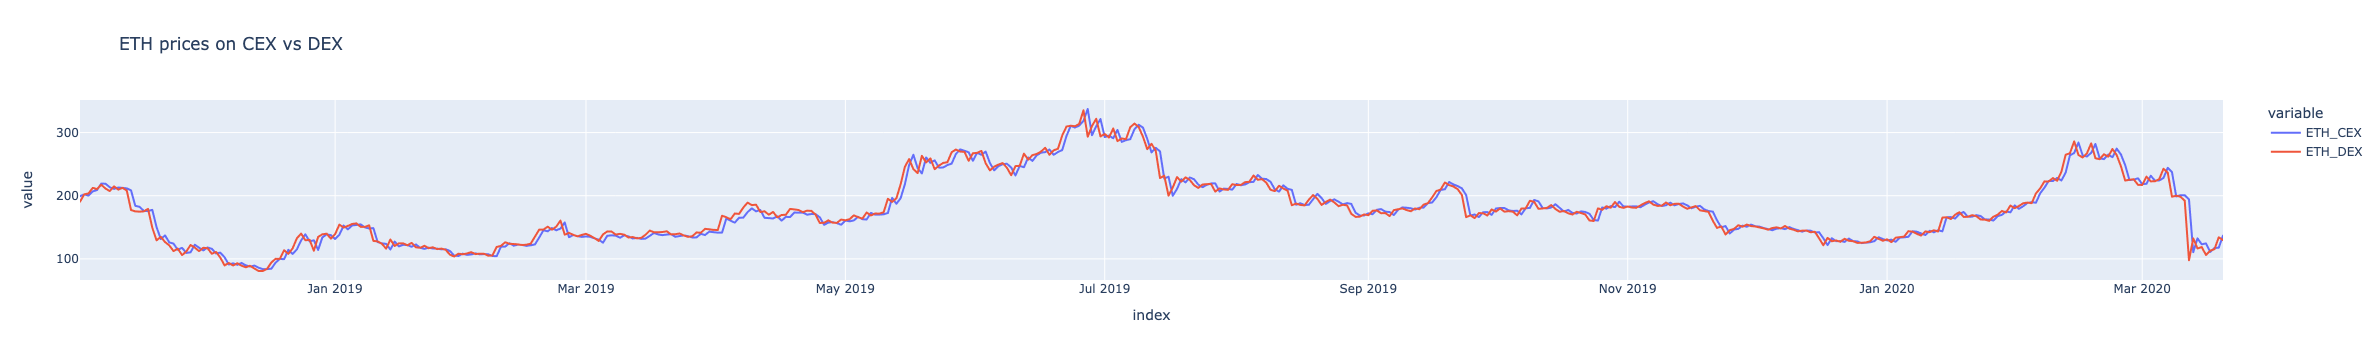

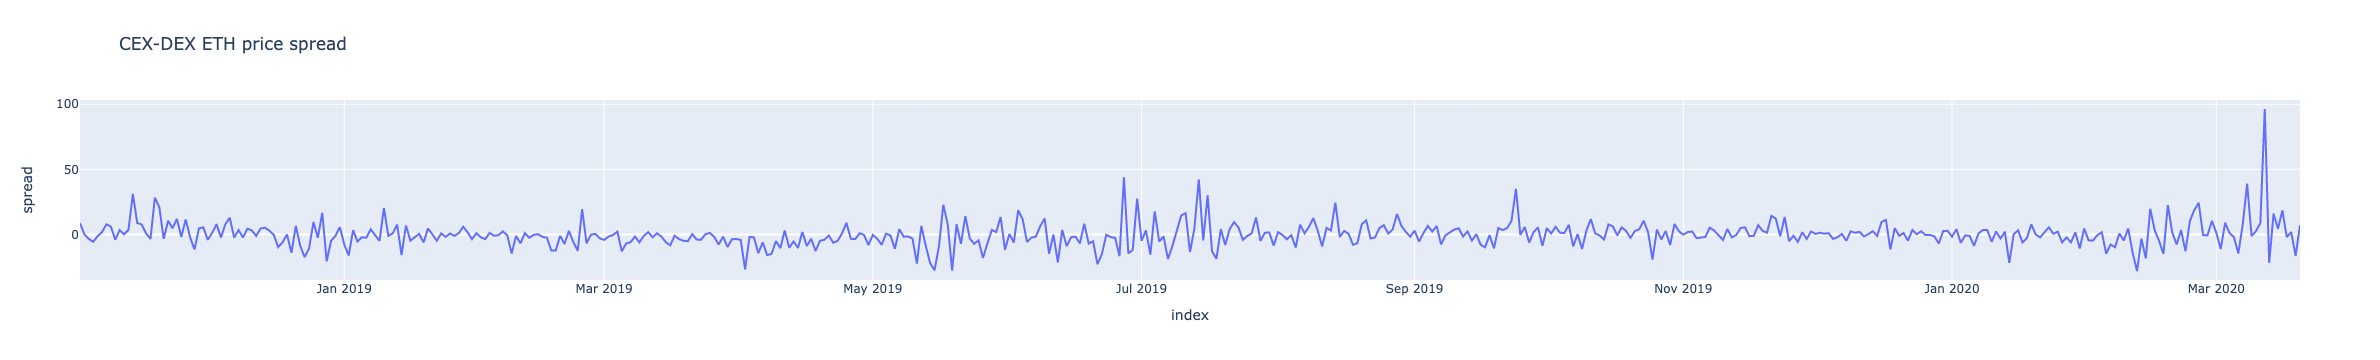

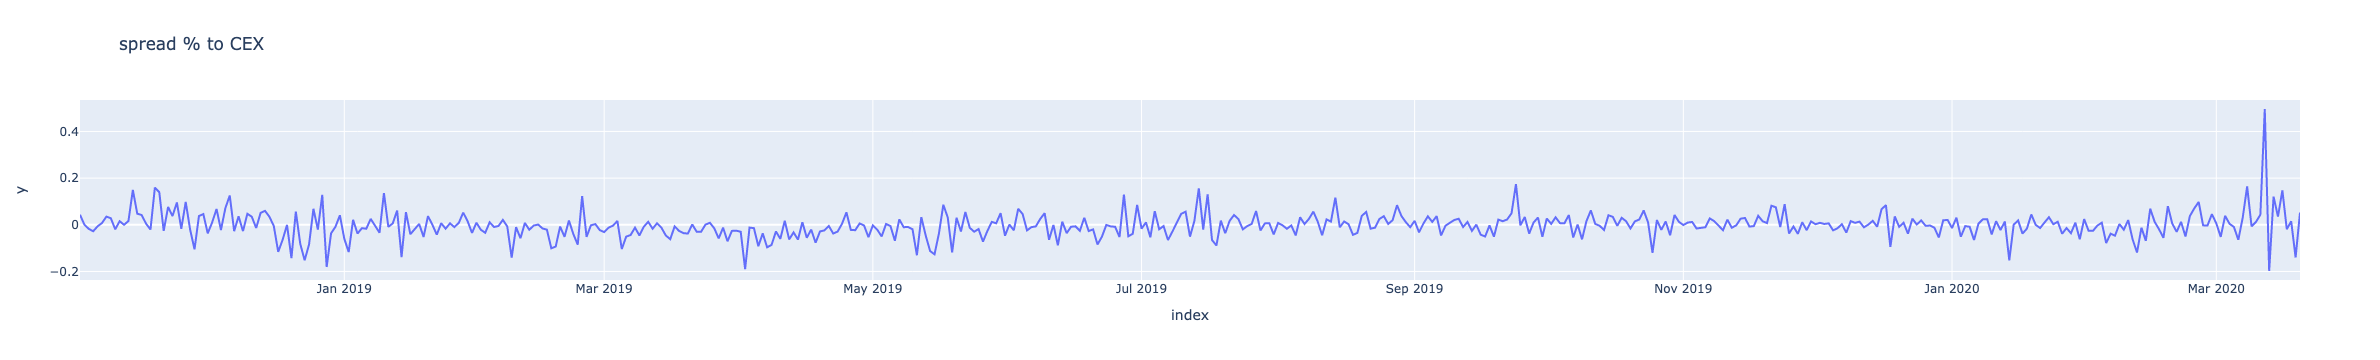

In [239]:
fig = px.line(
    eth_price,
    x=eth_price.index,
    y=eth_price.columns[:2],
    title='ETH prices on CEX vs DEX'
)
fig.show()

fig=px.line(
    eth_price,
    x=eth_price.index,
    y=eth_price['spread'],
    title='CEX-DEX ETH price spread'
)
fig.show()

fig=px.line(
    eth_price,
    x=eth_price.index,
    y=eth_price['spread']/eth_price['ETH_CEX'],
    title='spread % to CEX'
)
fig.show()

In [235]:
eth_price['spread'].var()

103.06544769827651

In [236]:
(eth_price['spread']/eth_price['ETH_CEX']).var()

0.003062917300020845